In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as kb
import os
import time
import wandb
import sys
import random as rd

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])

layer = R()

In [3]:
class RevPINN(tf.keras.Model):
    
    def __init__(self):
            super(RevPINN, self).__init__()
        
            self.R = R()
            
            self.A1 = tf.keras.layers.Dense(55, activation='tanh')
            self.A2 = tf.keras.layers.Dense(55, activation='tanh')
            self.A3 = tf.keras.layers.Dense(2, activation='tanh')
            
            self.B1 = tf.keras.layers.Dense(55, activation='tanh')
            self.B2 = tf.keras.layers.Dense(55, activation='tanh')
            self.B3 = tf.keras.layers.Dense(2, activation='tanh')
            
            self.b3 = tf.keras.layers.Dense(55, activation='tanh')
            self.b2 = tf.keras.layers.Dense(55, activation='tanh')
            self.b1 = tf.keras.layers.Dense(2, activation='tanh')
            
            self.a3 = tf.keras.layers.Dense(55, activation='tanh')
            self.a2 = tf.keras.layers.Dense(55, activation='tanh')
            self.a1 = tf.keras.layers.Dense(2, activation='tanh')
            
    def call(self, input_tensor, training=False):
        
            ###########
            
            xA = self.R(input_tensor)
            
            A = self.A1(xA)
            A = self.A2(A)
            A = self.A3(A)

            B = self.B1(A)
            B = self.B2(B)
            B = self.B3(B)
            
            xB = self.R(B)

            b = self.b3(xB)
            b = self.b2(b)
            b = self.b1(b)

            a = self.a3(b)
            a = self.a2(a)
            out = self.a1(a)    
            
            return out


In [13]:
model = RevPINN()

In [5]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')

In [14]:
#train_batch = 30000

x_train = np.array(x)
x_train = x_train.astype(np.float32)

y_train = np.array(y)
y_train = y_train.astype(np.float32)

#a_train = np.array(a)
#a_train = a_train.astype(np.float32)

#x_val = x_train[-val_len:]
#y_val = y_train[-val_len:]

#x_train = x_train[:-val_len]
#y_train = y_train[:-val_len]

#val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#val_dataset = val_dataset.batch(val_batch)

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, a_train, a_train))
#train_dataset = train_dataset.batch(train_batch)

In [15]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        print(lr)
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [20]:
history = model.fit(x_train, y_train, batch_size = 50000, epochs = 1000, callbacks=[callback],  verbose=1) #np.array(x), [np.array(y),a,a]

Epoch 1/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0014 - accuracy: 0.9705
Epoch 2/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.0013 - accuracy: 0.9706
Epoch 3/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.0013 - accuracy: 0.9706
Epoch 4/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.0013 - accuracy: 0.9706
Epoch 5/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0013 - accuracy: 0.9706
0.0003697193751577288
Epoch 6/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.0013 - accuracy: 0.9706
0.00036934984382241964
Epoch 7/1000
2/2 [==============================] - 0s 69ms/step - loss: 0.0014 - accuracy: 0.9706
0.000368980661733076
Epoch 8/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0014 - accuracy: 0.9707
0.00036861185799352825
Epoch 9/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.0014 - accuracy: 0.9706
0.000368243432603776

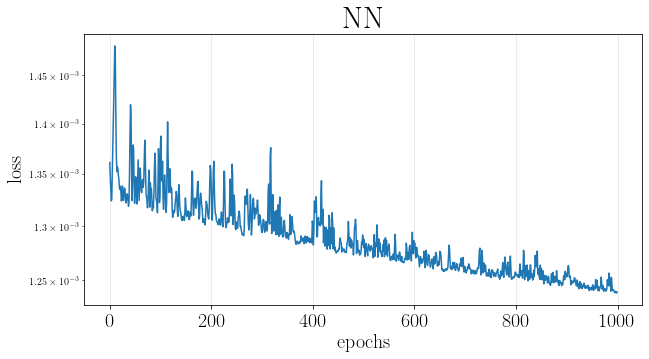

In [21]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")